In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12

In [2]:
train = pd.read_csv(r"Train.csv")
test= pd.read_csv(r"Test.csv")
submit = pd.read_csv(r"Sample_Submission.csv")

In [3]:
print("Train shape: " + str(train.shape))
print("Test shape: " + str(test.shape))
train.head()

Train shape: (18288, 3)
Test shape: (5112, 2)


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
from math import floor
#split the train data into training set and valid set
train = train.loc[:floor(2*train.shape[0]/3)]
valid = train.loc[floor(2*train.shape[0]/3):]
train.set_index('Datetime', inplace = True)
valid.set_index('Datetime', inplace = True)
test.set_index('Datetime', inplace = True)

In [5]:
print (train.shape)
print (valid.shape)
train.head()

(12193, 2)
(4065, 2)


,ID,Count
Datetime,,
25-08-2012 00:00,0,8
25-08-2012 01:00,1,2
25-08-2012 02:00,2,6
25-08-2012 03:00,3,2
25-08-2012 04:00,4,2


In [6]:
#parsing the datetime data 
dataparse = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y %H:%M")
train.index = train.index.map(dataparse)
valid.index = valid.index.map(dataparse)
test.index = test.index.map(dataparse)
train.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

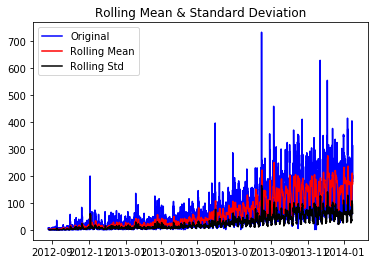

Results of Dickey-Fuller Test:
Test Statistic                -5.870107e+00
p-value                        3.255333e-07
#Lags Used                     4.000000e+01
Number of Observations Used    1.215200e+04
Critical Value (1%)           -3.430888e+00
Critical Value (5%)           -2.861778e+00
Critical Value (10%)          -2.566897e+00
dtype: float64


In [8]:
test_stationarity(train['Count'])

In [9]:
train_log = np.log(train['Count'])

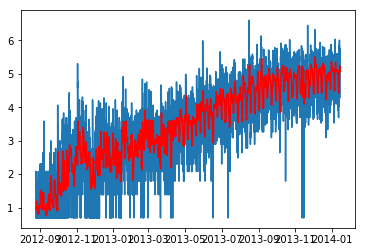

In [10]:
moving_avg = train_log.rolling(24).mean()
plt.plot(train_log)
plt.plot(moving_avg, color = 'red')

In [11]:
#removing the increasing trend 
train_log_moving_avg_diff = train_log - moving_avg

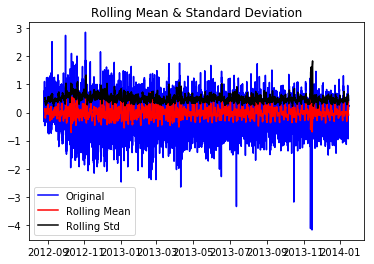

Results of Dickey-Fuller Test:
Test Statistic                   -22.510569
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [12]:
# Since we are taking the average of 24 values, rolling mean is not defined for the first 23 values. (NaN)
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

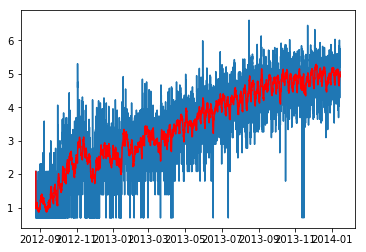

In [13]:
expwighted_avg = train_log.ewm(halflife=24).mean()
plt.plot(train_log)
plt.plot(expwighted_avg, color='red')

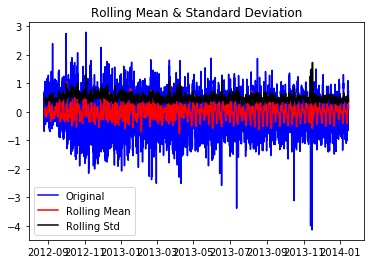

Results of Dickey-Fuller Test:
Test Statistic                   -20.177390
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12152.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [14]:
#removing the trend of increasing
train_log_ewma_diff = train_log - expwighted_avg
test_stationarity(train_log_ewma_diff)

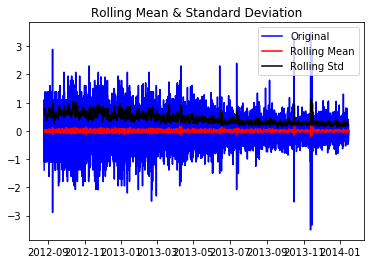

Results of Dickey-Fuller Test:
Test Statistic                   -21.889631
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12151.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [15]:
train_log_diff = train_log - train_log.shift()
test_stationarity(train_log_diff.dropna())

In [16]:
train_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64

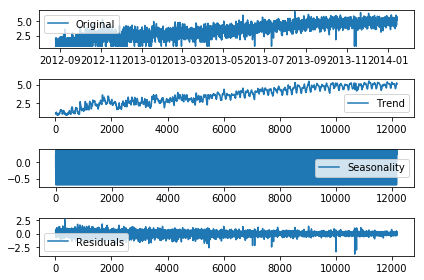

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

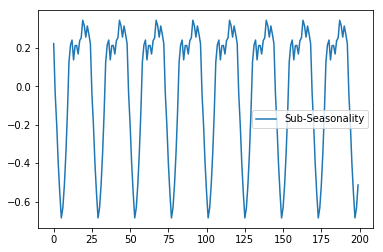

In [18]:
#A closer look at the seasonality 
plt.plot(seasonal[:200],label='Sub-Seasonality')
plt.legend(loc='best')

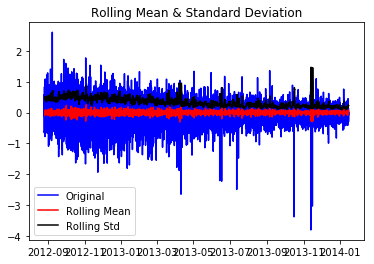

Results of Dickey-Fuller Test:
Test Statistic                   -28.600884
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [19]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

"plt.subplot(121) \nplt.plot(lag_acf)\nplt.axhline(y=0,linestyle='--',color='gray')\nplt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')\nplt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')\nplt.title('Autocorrelation Function')\n#Plot PACF:\nplt.subplot(122)\nplt.plot(lag_pacf)\nplt.axhline(y=0,linestyle='--',color='gray')\nplt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')\nplt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')\nplt.title('Partial Autocorrelation Function')\nplt.tight_layout()"

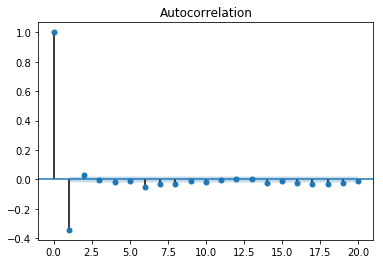

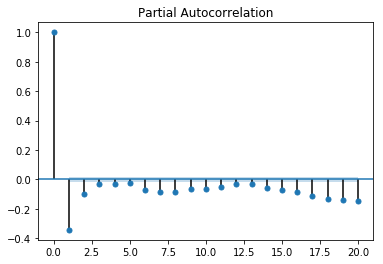

In [20]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics import tsaplots
lag_acf = tsaplots.plot_acf(train_log_diff.dropna(), lags=20)
lag_pacf = tsaplots.plot_pacf(train_log_diff.dropna(), lags=20, method='ols')
#Plot ACF: 
"""plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()"""

In [21]:
train_log_diff.dropna().head()

Datetime
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
2012-08-25 05:00:00    0.000000
Name: Count, dtype: float64

# Now we will apply simple to simpler models and check RMSE for each

# AR model

In [22]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RMSE: 48.7156')

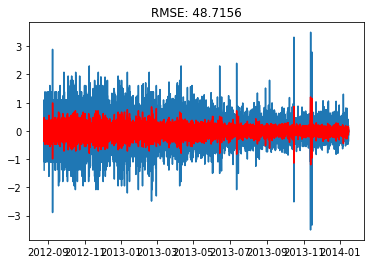

In [23]:
import math

model = ARIMA(train_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f'% math.sqrt(sum((results_AR.fittedvalues-train_log_diff.dropna())**2)))

# MA model

C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RMSE: 48.7156')

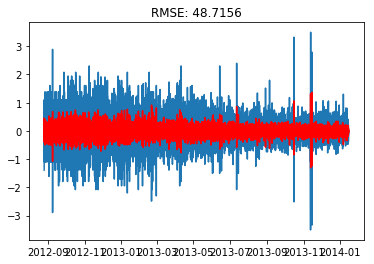

In [25]:
model = ARIMA(train_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% math.sqrt(sum((results_AR.fittedvalues-train_log_diff.dropna())**2)))

# ARIMA model

C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RMSE: 48.4530')

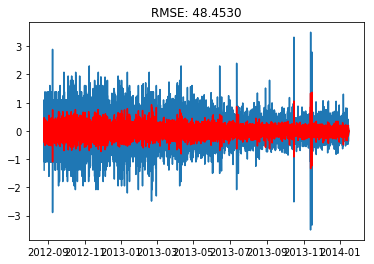

In [26]:
model = ARIMA(train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% math.sqrt(sum((results_MA.fittedvalues-train_log_diff.dropna())**2)))

In [27]:
#bring the differencing back to the original scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [28]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [29]:
# Tried on ARIMA model 
model = ARIMA(train_log.dropna(), order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Dhruba\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Datetime
2012-08-25 01:00:00    0.000294
2012-08-25 02:00:00    0.457377
2012-08-25 03:00:00   -0.236857
2012-08-25 04:00:00    0.323809
2012-08-25 05:00:00    0.122112
dtype: float64


In [30]:
start = train.shape[0]
end = start + valid.shape[0]
valid_predict_diff = results_ARIMA.predict(start = start-1, end = end-2, typ = 'levels')
print (valid_predict_diff.head())
print (valid_predict_diff.tail())

2014-01-15 00:00:00    5.321110
2014-01-15 01:00:00    5.241479
2014-01-15 02:00:00    5.241773
2014-01-15 03:00:00    5.242067
2014-01-15 04:00:00    5.242362
Freq: H, dtype: float64
2014-07-03 04:00:00    6.435425
2014-07-03 05:00:00    6.435719
2014-07-03 06:00:00    6.436013
2014-07-03 07:00:00    6.436307
2014-07-03 08:00:00    6.436602
Freq: H, dtype: float64


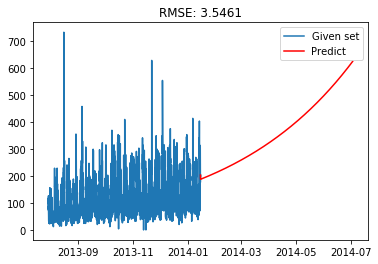

In [31]:
check_prediction_log(valid_predict_diff, valid)

# Predicting on the test set

In [32]:
def check_prediction_log_test(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')

In [33]:
start = train.shape[0]
end = start + test.shape[0]
test_predict_diff = results_ARIMA.predict(start = start-1, end = end-2, typ = 'levels')
print (test_predict_diff.head())
print (test_predict_diff.tail())

2014-01-15 00:00:00    5.321110
2014-01-15 01:00:00    5.241479
2014-01-15 02:00:00    5.241773
2014-01-15 03:00:00    5.242067
2014-01-15 04:00:00    5.242362
Freq: H, dtype: float64
2014-08-15 19:00:00    6.743398
2014-08-15 20:00:00    6.743692
2014-08-15 21:00:00    6.743986
2014-08-15 22:00:00    6.744280
2014-08-15 23:00:00    6.744574
Freq: H, dtype: float64


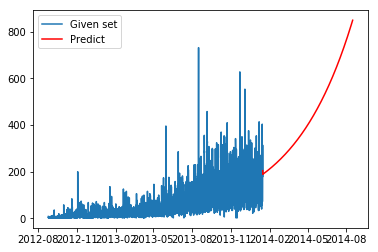

In [34]:
check_prediction_log_test(test_predict_diff, train)